# Simulating mutations with msprime

First, should talk about why you might not always need to do this.

In msprime simulations, the genealogy is independent of the genetic variation (Actually I don't think this is quite the right way to phrase it, because the mutation table is conditional on a specific tree... think more). You simulate the underlying genealogy first, as a set of node and edge tables, and *then* if desired, you simulate mutations to go with that genealogical structure. However, in many situations, the genealogy is all you need. 

Think carefully. Does your application *need* information about alleles and mutations? If not, save yourself (and your computer) some effort. The genealogy will in itself give you information about times, MRCAs, segments of identity-by-descent amongst other things. In later worksheetw we will see more examples of analyses that do not rely on mutations.

But in this worksheet, we're going to focus on how to do mutation simulations, should this be needed....

## A basic tree sequence to work with + packages

In [1]:
import msprime
from IPython.display import SVG
msprime.__version__

'1.1.1'

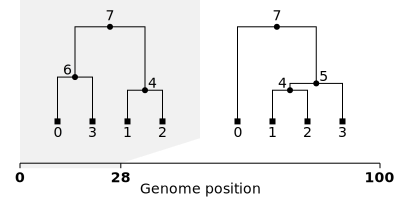

In [2]:
ts = msprime.sim_ancestry(2, sequence_length=100, random_seed=1987, recombination_rate=0.001)
SVG(ts.draw_svg())

## Syntax + accessing the variants

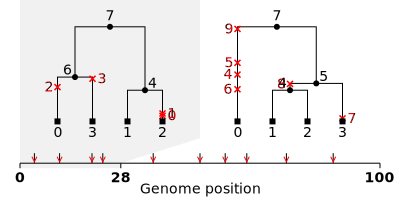

In [3]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022)
SVG(mts.draw_svg())

In [4]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,2,0.16174547,T,-1,b''
1,1,2,0.23091606,T,-1,b''
2,2,0,0.99502258,A,-1,b''
3,3,3,1.23761207,G,-1,b''
4,4,0,1.35806297,C,-1,b''
5,5,0,1.70000009,T,-1,b''
6,6,0,0.93177079,C,-1,b''
7,7,3,0.08711580,G,-1,b''
8,8,4,1.08735976,T,-1,b''
9,9,0,2.68279273,G,-1,b''


In [5]:
mts.tables.sites

id,position,ancestral_state,metadata
0,4.00000000,G,b''
1,11.00000000,C,b''
2,20.00000000,C,b''
3,23.00000000,T,b''
4,37.00000000,A,b''
5,50.00000000,G,b''
6,57.00000000,T,b''
7,63.00000000,C,b''
8,74.00000000,A,b''
9,87.00000000,C,b''


Other tables the same as in the original tree sequence.

In [6]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('G', 'T')	[0 0 1 0]
11.0	('C', 'T')	[0 0 1 0]
20.0	('C', 'A')	[1 0 0 0]
23.0	('T', 'G')	[0 0 0 1]
37.0	('A', 'C')	[1 0 0 0]
50.0	('G', 'T')	[1 0 0 0]
57.0	('T', 'C')	[1 0 0 0]
63.0	('C', 'G')	[0 0 0 1]
74.0	('A', 'T')	[0 1 1 0]
87.0	('C', 'G')	[1 0 0 0]


## Mutation models and 'stackability' of mutations

By default, uses a Jukes-Cantor model of mutations (mention some features of this model -- changes from 1 nucleotide type to another are all equally likely, right?), but others are possible. For full list (provide link to docs page), but here are some notable examples you may want to use instead:

### HKY

Under JK model, all transitions from one nucleotide to another are equally likely (Is the rate the rate for each of these types, or overall?). However, in many situations you'll want nucleotide transitions (A<->G), (C<->T) to be more likely than nucleotide tranversions (all others). Can do this with the HKY model, where you specify `kappa`, scaling parameter by which frequencies of each individual transition type is modified.

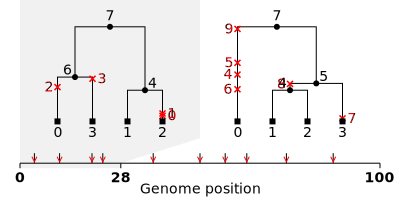

In [9]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022, model=msprime.HKY(kappa=2))
SVG(mts.draw_svg())

(Best way to show which of therse are the transversions, and which the transitions?)

### GTR

What if you want to specify each nucleotide substitution individually?
(Lots of parameters in this one -- maybe they should just look at the docs to see what this means)

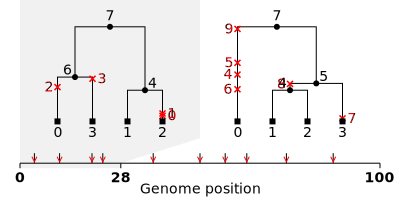

In [10]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022, model=msprime.GTR(relative_rates=[1,2,1,2,1,2]))
SVG(mts.draw_svg())

### Models where the mutations aren't nucleotides

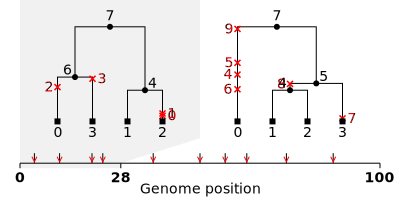

In [11]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022,
                            model=msprime.PAM())
SVG(mts.draw_svg())

In [12]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('P', 'T')	[0 0 1 0]
11.0	('E', 'G')	[0 0 1 0]
20.0	('E', 'A')	[1 0 0 0]
23.0	('P', 'S')	[0 0 0 1]
37.0	('A',)	[0 0 0 0]
50.0	('L',)	[0 0 0 0]
57.0	('T', 'K')	[1 0 0 0]
63.0	('G',)	[0 0 0 0]
74.0	('D', 'S')	[0 1 1 0]
87.0	('I', 'K')	[1 0 0 0]


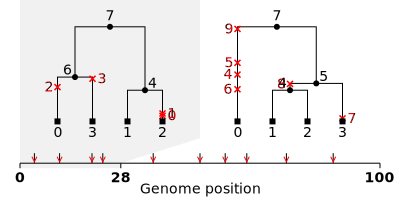

In [13]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022,
                            model=msprime.InfiniteAlleles())
SVG(mts.draw_svg())

'mutation flags', are they a thing?

mention the SLiM mutation model, for anyone using SLiM

### Make-your-own mutation model!

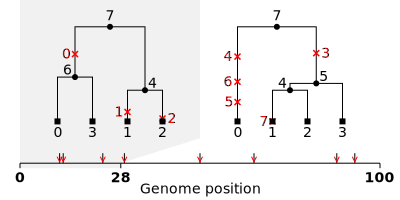

In [17]:
alleles = ["💩", "🎄", "🔥"]
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = [1.0, 0.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.8, 0.2],
                         [1.0, 0.0, 0.0]]
)
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=1, model=model)
SVG(mts.draw_svg())

## Variation in mutation rates across the genome, and across the time (sort of)

In [ ]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install msprime --upgrade